### Imports and configuration

In [12]:
%matplotlib inline

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio

from rasterio.enums import Resampling
from sklearn.metrics import mean_squared_error

matplotlib.rc('figure', dpi=125)

binary_cmap = matplotlib.colors.ListedColormap(['green', 'blue'])
confusion_cmap = matplotlib.colors.ListedColormap(['gray', 'green', 'red', 'blue'])

### Helper functions

In [40]:
# proj crs NAD 1983 UTM Zone 18N
# geographic crs NAD 1983

def couple(surge_fpath, riv_fpath, compound_fpath, alpha, write_tiff, return_array):

    with rio.open(surge_fpath) as ds_in:
        surge_inun = ds_in.read(1, masked=True)
        surge_inun_profile = ds_in.profile
    msk = surge_inun.copy().mask # save mask, will get wiped out on next lines
    surge_inun[surge_inun>3.4e+38] = np.nan # set nodata
    surge_inun[surge_inun < 0] = 0
    surge_inun = np.ma.masked_array(surge_inun, msk)
    # save mask with GDAL convetion for writing later
    # https://rasterio.readthedocs.io/en/latest/topics/masks.html
    w_msk = (~surge_inun.mask * 255).astype('uint8')

    with rio.open(riv_fpath) as ds_in:
        riv_inun = ds_in.read(1, masked=True)
    riv_inun[riv_inun>3.4e+38] = np.nan # set nodata
    riv_inun[riv_inun<0] = 0

    # give riv_inun one extra row and col to match shapes with surge_inun
    # this is due to how ArcGIS projected raster
    # extra row and col will get masked out when written to .tif
    newrow = np.empty(riv_inun.shape[1])
    newrow.fill(np.nan)
    riv_inun = np.vstack([riv_inun,newrow])

    newcol = np.empty([riv_inun.shape[0],1])
    newcol.fill(np.nan)
    riv_inun = np.hstack([riv_inun,newcol])

    # avoid divide by zero errors
    ratio_adj = 0.001 # 0.001 m = 0.04 in
    ratio_array = (surge_inun + ratio_adj) / (riv_inun + ratio_adj)

    # vary alpha (see eqn. 2 from SI 2022 paper)
    # calculate compound inundation accounting for transition zone
    # implement eqn. 2 from SI 2022 paper
    compound_inun = np.where(
        ratio_array > 1, # coastal zone
        surge_inun,
        np.where(
            ratio_array <= alpha*riv_inun, # hydrologic zone
            riv_inun,
            np.where(
                (ratio_array <= 1 & (ratio_array > alpha*riv_inun)), # transition zone
                ratio_array*np.maximum(surge_inun, riv_inun) + (1 - ratio_array)*(surge_inun + riv_inun),
                np.nan, # else assign NaN
        )))

    if write_tiff:
        # write raster with internal mask (no .msk sidecar)
        with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
            with rio.open(compound_fpath, 'w', **surge_inun_profile) as ds_out:
                ds_out.write(compound_inun,1)
                ds_out.write_mask(w_msk)

    if return_array:
        return np.ma.masked_array(compound_inun,msk)

# remove infinite values generated from dividing by 0
def filter_inf(series):
    series = series[series != np.inf]
    return series

# get xy coords from geopandas dataframe in a given crs
def get_points(gpd_df, dest_crs):
    pts = gpd_df.to_crs(dest_crs).geometry
    coords = [(pt.xy[0][0], pt.xy[1][0]) for pt in pts]
    return coords

# sample rasterio dataset with xy coords
def sample_rio_ds(rio_ds, coords):
    sampled_vals = np.array([x[0] for x in rio_ds.sample(coords)])
    # clean bad values from unfiltered DEM
    sampled_vals[sampled_vals < 0] = 0
    sampled_vals[sampled_vals > 3.4e+38] = np.nan
    return sampled_vals

def ft_to_m(series):
    return series * 0.3048

def percent_bias(predicted, observed):
    return 100*((predicted - observed) / observed)

# makes inundation depth array binary
# 0 is not inundated and 1 is inundated
def make_binary(in_array):
    binary_array = in_array.copy().astype('uint8')
    binary_array = np.where(binary_array <= int(0), int(0), int(1))
    binary_array[binary_array==np.nan] = int(0)
    if isinstance(in_array, np.ma.MaskedArray):
        binary_array = np.ma.masked_array(binary_array, in_array.mask).astype('uint8')
    return binary_array.astype('uint8')

# takes two binary arrays where for each cell
# 0 is not inundated and 1 is inundated
def make_confusion_plot(truth_array, eval_array):
    confusion_classified = np.where(
        ((truth_array == 0) & (eval_array == 0)), 0, # TN = 0
        np.where(
            ((truth_array == 0) & (eval_array == 1)), 1, # FP = 1
            np.where(
                ((truth_array == 1) & (eval_array == 0)), 2, # FN = 2
                np.where(
                    ((truth_array == 1) & (eval_array == 1)), 3, # TP = 3
                    np.nan # else assign NaN
    ))))
    return confusion_classified

def make_confusion_stats(confusion_plot_array):
    _, counts = np.unique(confusion_plot_array, return_counts=True)

    tn = counts[0]
    fp = counts[1]
    fn = counts[2]
    tp = counts[3]

    prop_cor = (tp+tn)/(tn+fp+fn+tp)
    bias_ratio = (tp+fp)/(tp+fn)
    hit_rate = tp/(tp+fn)
    fitness = tp/(tp+fp+fn)

    print(
        f"{'True Negative (TN):':<20}{tn:>15}",
        f"\n{'False Positive (FP):':<20}{fp:>15}",
        f"\n{'False Negative (FN):':<20}{fn:>15}",
        f"\n{'True Postive (TP):':<20}{tp:>15}",
        "\n",
        f"\n{'Proportion Correct:':<20}{round(prop_cor,4):>15}",
        f"\n{'Bias Ratio:':<20}{round(bias_ratio,4):>15}",
        f"\n{'Hit Rate:':<20}{round(hit_rate,4):>15}",
        f"\n{'Fitness':<20}{round(fitness,4):>15}"
    )


def imshow_binary_array(in_array, save_path):
    fig, ax = plt.subplots()

    cax = ax.imshow(
        in_array,
        vmin = 0,
        vmax = 1,
        cmap = binary_cmap
        )

    cbar = fig.colorbar(
        cax,
        ticks=[0,.25,0.5,0.75,1],
        ax=ax,
        fraction=0.046,
        pad=0.03
        )

    cbar.ax.set_yticklabels(
        ['','Not inundated','','Inundated',''],
        rotation=90,
        va='center' # set vertical alignment
        )

    if save_path is not None:
        fig.tight_layout()
        plt.savefig(save_path, facecolor = 'w')
        
    plt.show()

def imshow_confusion(in_array, save_path):
    fig, ax = plt.subplots()

    cax = ax.imshow(
        in_array,
        vmin = 0,
        vmax = 3,
        cmap = confusion_cmap
        )

    cbar = fig.colorbar(
        cax,
        ticks=np.arange(0,4,0.375),
        ax=ax,
        fraction=0.046,
        pad=0.03
        )

    cbar.ax.set_yticklabels(
        ['', 'TN', '', 'FP', '', 'FN', '', 'TP', '','',''],
        rotation=90,
        va = 'center' # centered vertical alignment
        )

    if save_path is not None:
        fig.tight_layout()
        plt.savefig(save_path, facecolor = 'w')
        
    plt.show()

### Run coupling function and view result

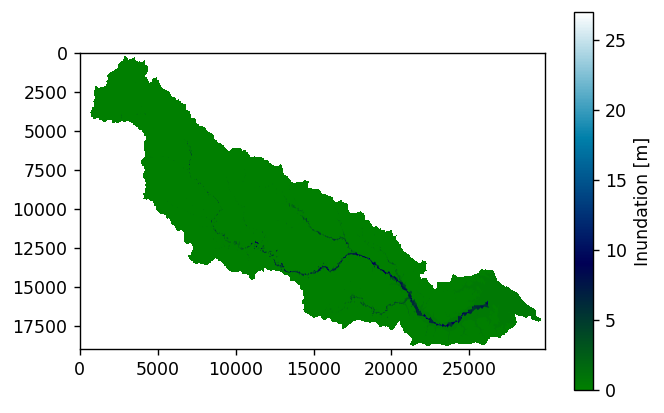

In [9]:
# make compound inundation map
# sep 19 2018 9pm

florence_SEP19 = couple(
    surge_fpath = 'data_github/inun_surge_201809192100.tif',
    riv_fpath = 'data_github/030202_201809192100_depth_map_projUTM18n.tif',
    compound_fpath = 'data_github/compound_inun_SEP19_alpha1.tif',
    alpha = 1, # see eqn. 2 in SI 2022 paper
    write_tiff = True,
    return_array = True
)

plt.close('all')

fig, ax = plt.subplots()

cbar = ax.imshow(
    florence_SEP19,
    vmin=0,
    vmax=27, # max is 24.99
    cmap=plt.get_cmap('ocean')
    )

fig.colorbar(cbar,label='Inundation [m]',ax=ax)

### Validation calcs with riverine HWM and coastal PWL

In [19]:
# open and store rasters

compound_inun = rio.open('data_github/compound_inun_SEP19_alpha1.tif','r')
riv_inun = rio.open('data_github/030202_201809192100_depth_map_projUTM18n.tif','r')
surge_inun = rio.open('data_github/inun_surge_201809192100.tif','r')
dem = rio.open('data_github/nc_roi_huc6.tif')

rasters = [compound_inun,riv_inun,surge_inun,dem]

# EPSG:26918 is UTM Zone 18N for North Carolina
# riverine high water marks
val_riv = gpd.read_file('data_github/shp/HWM.shp')
val_riv.index = range(len(val_riv))
coords_utm_riv = get_points(val_riv, 'epsg:26918') 
# surge peak water levels
val_surge = gpd.read_file('data_github/shp/Peak_water_level.shp')
val_surge.index = range(len(val_surge))
coords_utm_surge = get_points(val_surge, 'epsg:26918')

# sample rasters at riverine HWM shapefile points
val_riv['compound_inun_m_surf'] = sample_rio_ds(compound_inun, coords_utm_riv)
val_riv['riv_inun_m_surf'] = sample_rio_ds(riv_inun, coords_utm_riv)
val_riv['surge_inun_m_surf'] = sample_rio_ds(surge_inun, coords_utm_riv)
val_riv['dem'] = sample_rio_ds(dem, coords_utm_riv)

# add surface elevation to obtain height above NAVD88
val_riv['compound_inun_m_navd88'] = val_riv['compound_inun_m_surf'] + val_riv['dem']
val_riv['riv_inun_m_navd88'] = val_riv['riv_inun_m_surf'] + val_riv['dem']
val_riv['surge_inun_m_navd88'] = val_riv['surge_inun_m_surf'] + val_riv['dem']

# sample rasters at surge PWL shapefile points
val_surge['compound_inun_m_surf'] = sample_rio_ds(compound_inun, coords_utm_surge)
val_surge['riv_inun_m_surf'] = sample_rio_ds(riv_inun, coords_utm_surge)
val_surge['surge_inun_m_surf'] = sample_rio_ds(surge_inun, coords_utm_surge)
val_surge['dem'] = sample_rio_ds(dem, coords_utm_surge)

# add surface elevation to obtain height above NAVD88
val_surge['compound_inun_m_navd88'] = val_surge['compound_inun_m_surf'] + val_surge['dem']
val_surge['riv_inun_m_navd88'] = val_surge['riv_inun_m_surf'] + val_surge['dem']
val_surge['surge_inun_m_navd88'] = val_surge['surge_inun_m_surf'] + val_surge['dem']

# percent bias
## riverine
# convert ft to m
val_riv['hwm_m_above_navd88'] = ft_to_m(val_riv['elev_ft'])
# calculate percent bias
val_riv['hwm_compound_PB_navd88'] = percent_bias(val_riv['compound_inun_m_navd88'], val_riv['hwm_m_above_navd88']) 
val_riv['hwm_riv_PB_navd88'] = percent_bias(val_riv['riv_inun_m_navd88'], val_riv['hwm_m_above_navd88']) 
val_riv['hwm_surge_PB_navd88'] = percent_bias(val_riv['surge_inun_m_navd88'], val_riv['hwm_m_above_navd88']) 
# remove infinite values from dividing by 0
val_riv['hwm_compound_PB_navd88'] = filter_inf(val_riv['hwm_compound_PB_navd88'])
val_riv['hwm_riv_PB_navd88'] = filter_inf(val_riv['hwm_riv_PB_navd88'])
val_riv['hwm_surge_PB_navd88'] = filter_inf(val_riv['hwm_surge_PB_navd88'])

## surge
# convert ft to m
val_surge['pwl_m_above_navd88'] = ft_to_m(val_surge['peak_stage'])
# calculate percent bias
val_surge['pwl_compound_PB_navd88'] = percent_bias(val_surge['compound_inun_m_navd88'], val_surge['pwl_m_above_navd88']) 
val_surge['pwl_riv_PB_navd88'] = percent_bias(val_surge['riv_inun_m_navd88'], val_surge['pwl_m_above_navd88']) 
val_surge['pwl_surge_PB_navd88'] = percent_bias(val_surge['surge_inun_m_navd88'], val_surge['pwl_m_above_navd88'])
# remove infinite values from dividing by 0
val_surge['pwl_compound_PB_navd88'] = filter_inf(val_surge['pwl_compound_PB_navd88'])
val_surge['pwl_riv_PB_navd88'] = filter_inf(val_surge['pwl_riv_PB_navd88'])
val_surge['pwl_surge_PB_navd88'] = filter_inf(val_surge['pwl_surge_PB_navd88'])

# RMSE
rmse_hwm_compound = mean_squared_error(
    val_riv['hwm_m_above_navd88'],
    val_riv['compound_inun_m_navd88'],
    squared=False)
rmse_hwm_riv = mean_squared_error(
    val_riv['hwm_m_above_navd88'],
    val_riv['riv_inun_m_navd88'],
    squared=False)
rmse_hwm_surge = mean_squared_error(
    val_riv['hwm_m_above_navd88'],
    val_riv['surge_inun_m_navd88'],
    squared=False) 

rmse_pwl_compound = mean_squared_error(
    val_surge['pwl_m_above_navd88'],
    val_surge['compound_inun_m_navd88'],
    squared=False) 
rmse_pwl_riv = mean_squared_error(
    val_surge['pwl_m_above_navd88'],
    val_surge['riv_inun_m_navd88'],
    squared=False) 
rmse_pwl_surge = mean_squared_error(
    val_surge['pwl_m_above_navd88'],
    val_surge['surge_inun_m_navd88'],
    squared=False)

### Visualize validation with riverine HWM and coastal PWL


HWM--Compound RMSE:	4.256583159022278
HWM--Riverine RMSE:	4.205359278614854
HWM--Surge RMSE:	3.8122765247285044

PWL--Compound RMSE:	2.1249256555760696
PWL--Riverine RMSE:	2.3953322936908767
PWL--Surge RMSE:	2.1911090371225566


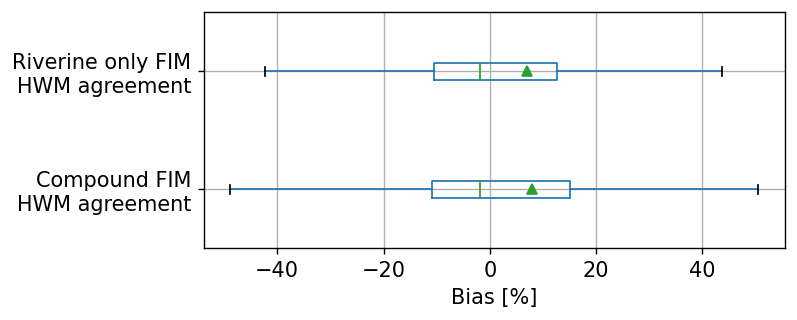

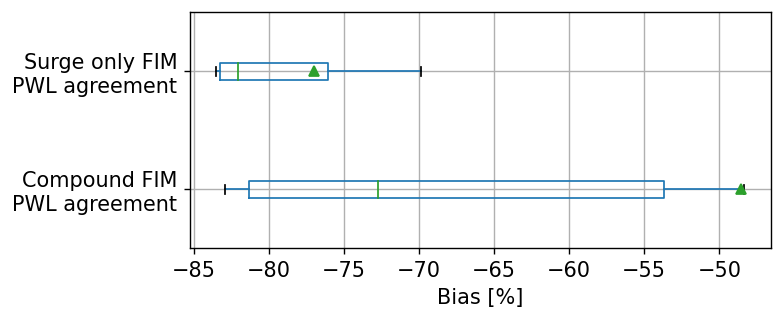

In [20]:
print()
print(f'HWM--Compound RMSE:\t{rmse_hwm_compound}')
print(f'HWM--Riverine RMSE:\t{rmse_hwm_riv}')
print(f'HWM--Surge RMSE:\t{rmse_hwm_surge}')
print()
print(f'PWL--Compound RMSE:\t{rmse_pwl_compound}')
print(f'PWL--Riverine RMSE:\t{rmse_pwl_riv}')
print(f'PWL--Surge RMSE:\t{rmse_pwl_surge}')

plt.close('all')

fontsize = 12
fig_size = (6,2.5)

# rename columns for nice plot labels
val_riv_clean_names = val_riv.rename(
    columns={
        'hwm_compound_PB_navd88': 'Compound FIM\nHWM agreement',
        'hwm_riv_PB_navd88': 'Riverine only FIM\nHWM agreement'
        })
val_surge_clean_names = val_surge.rename(
    columns={
        'pwl_compound_PB_navd88': 'Compound FIM\nPWL agreement',
        'pwl_surge_PB_navd88': 'Surge only FIM\nPWL agreement'
        })

# make plots
hwm_bplot = val_riv_clean_names.boxplot(
    column = [
        'Compound FIM\nHWM agreement',
        'Riverine only FIM\nHWM agreement'
    ],
    showmeans = True,
    showfliers = False,
    vert = False,
    fontsize = fontsize,
    figsize=fig_size
    )
hwm_bplot.set_xlabel('Bias [%]',fontsize=fontsize)
plt.savefig(
    'data_github/hwm_boxplot_sep19.png',
    bbox_inches="tight",
    facecolor='w'
    )
plt.show()

pwl_bplot = val_surge_clean_names.boxplot(
    column = [
        'Compound FIM\nPWL agreement',
        'Surge only FIM\nPWL agreement'
    ],
    showmeans = True,
    showfliers = False,
    vert = False,
    fontsize = fontsize,
    figsize=fig_size
    )
pwl_bplot.set_xlabel('Bias [%]',fontsize=fontsize)
plt.savefig(
    'data_github/pwl_boxplot_sep19.png',
    bbox_inches="tight",
    facecolor='w'
    )
plt.show()

## Validation with SAR imagery
### Make binary inundation extent arrays, resample to equal shape, plot

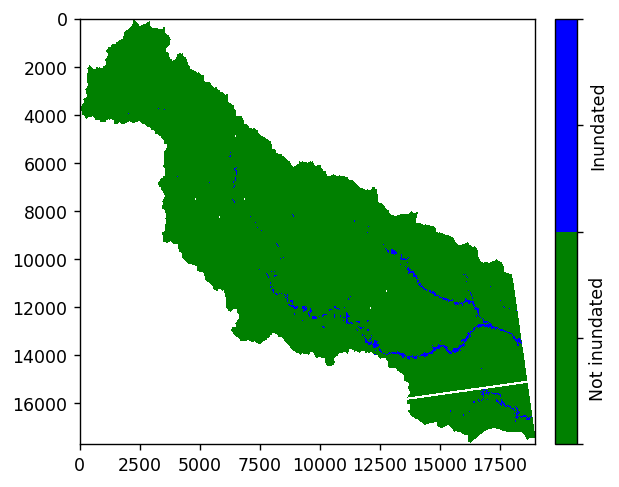

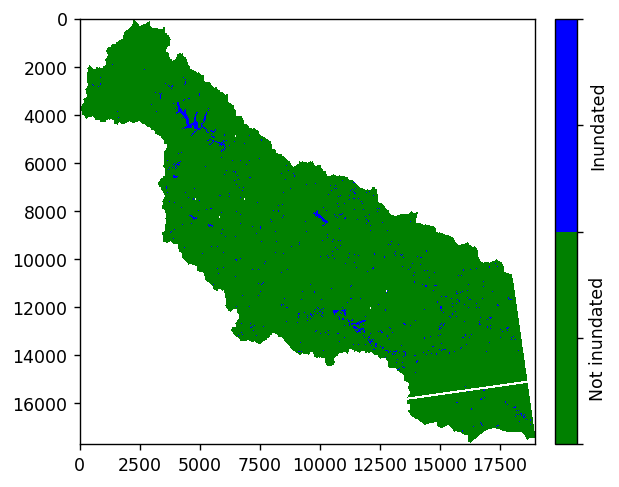

In [42]:
compound_inun_SAR_clip = rio.open('data_github/compound_inun_SEP19_alpha1_clipped.tif', 'r')
compound_inun_array = compound_inun_SAR_clip.read(1,masked=True)
compound_inun_array_binary = make_binary(compound_inun_array)

SAR_inun = rio.open('data_github/SAR_19SEP_clipped_proj_extr_msk.tif', 'r')
# resample band 1 of SAR_inun to shape of compound_inun
# with nearest neighbor interpolation
SAR_inun_array = SAR_inun.read(
    1,
    masked=True,
    out_shape=(
        compound_inun_array_binary.shape[0],
        compound_inun_array_binary.shape[1]
    ),
    resampling=Resampling.nearest
)

# assert compound inundation array and SAR inundation array have same shape
assert np.equal(
    compound_inun_array_binary.shape,
    SAR_inun_array.shape
    ).all()

plt.close('all')

# plot compound inundation binary array
imshow_binary_array(
    compound_inun_array_binary,
    save_path = 'data_github/binary_riv_sep19.png'
    )

# plot SAR binary raster
imshow_binary_array(
    SAR_inun_array,
    save_path = 'data_github/binary_sar_sep19.png'
    )

### Make confusion matrix, show stats, save .tif and .png

True Negative (TN):       119714072 
False Positive (FP):        2040510 
False Negative (FN):        7013445 
True Postive (TP):           214490 
 
Proportion Correct:          0.9298 
Bias Ratio:                   0.312 
Hit Rate:                    0.0297 
Fitness                      0.0231


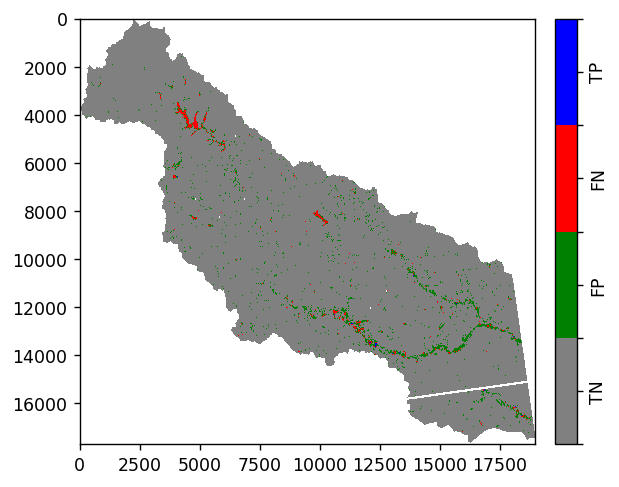

In [44]:
# takes two binary arrays where for each cell
# 0 is not inundated and 1 is inundated
confusion_SAR_compound = make_confusion_plot(SAR_inun_array, compound_inun_array_binary)

make_confusion_stats(confusion_SAR_compound)

# write raster with internal mask (no .msk sidecar)
write_prof = compound_inun_SAR_clip.profile
write_prof['compress'] = 'lzw'
w_msk = (~compound_inun_array.mask * 255).astype('uint8')
with rio.Env(GDAL_TIFF_INTERNAL_MASK=True):
    with rio.open(
        'data_github/confusion_SAR_compound_SEP19_alpha1.tif', 'w', 
        **write_prof) as ds_out:
        ds_out.write(confusion_SAR_compound,1)
        ds_out.write_mask(w_msk)

# plot and save confusion matrix coded fig
imshow_confusion(
    confusion_SAR_compound,
    save_path = 'data_github/confusion_SAR_compound_SEP19_alpha1.png'
    )